## ライブラリのインポート

In [1098]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import wxparams as wx
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## データの読み込み

In [1099]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
df = pd.concat([train, test], axis=0, ignore_index=True)

## 特徴量生成
降水量のカラムを作りたい

In [1100]:
# 日付や時間の列を生成
df = df.sort_values('datetime')
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = pd.to_datetime(df['datetime']).dt.strftime('%Y').astype('int64')
df['year_month'] = pd.to_datetime(df['datetime']).dt.strftime('%Y%m')
df['month'] = pd.to_datetime(df['datetime']).dt.strftime('%m').astype('int64')
df['day'] = pd.to_datetime(df['datetime']).dt.strftime('%d').astype('int64')
df['weekday'] = pd.to_datetime(df['datetime']).dt.strftime('%a')
df['hour'] = pd.to_datetime(df['datetime']).dt.strftime('%H').astype('int64')

#時間をsin,cosで表してみる -> intでそのまま渡した方が良い
def deg_2_rad(deg):
    rad = deg/180*np.pi
    return rad
df['hour_sin'] = np.sin(deg_2_rad(df['hour']*15))
df['hour_cos'] = np.cos(deg_2_rad(df['hour']*15))

# 時間帯の分類 ->精度落ちる
# 7-9 and 17-19 -> high
# 10-16 -> average
# 0-6 and 20-24 -> low
df['hour_trend'] = 'low'
df.loc[(df['hour']>=7) & (df['hour']<=9), 'hour_trend'] = 'high'
df.loc[(df['hour']>=10) & (df['hour']<=16), 'hour_trend'] = 'average'
df.loc[(df['hour']>=17) & (df['hour']<=19), 'hour_trend'] = 'high'

# 湿度0%は欠損値として補完 ->補完しないよりは良いが、使わない方が精度良い
# df.loc[df['windspeed']==0, 'windspeed'] = df['windspeed'].median()

# 利用者区分 若干精度上がる
df['casual_ratio'] = df['casual']/df['count']
df['registered_ratio'] = df['registered']/df['count']
df['campaign_flg'] = 0
df.loc[df['casual_ratio']>0.95,'campaign_flg'] = 1
# df['casual_ratio'].loc[df['casual_ratio']>0.95].count()/df['casual_ratio'].count()

# 天気関連 改善せず
df['td'] = wx.RH_to_Td(df['temp'], df['humidity'], formula="Bolton") #露点温度
df['t_td'] = wx.T_Td(df['temp'], df['td']) #湿数(飽和水蒸気量に達するまでの温度差。0に近いと雨が降りやすい)
df['humidity_abs'] = wx.Absolute_Humidity(df['temp'], df['td'], formula="Bolton") #絶対湿度

# 月平均 悪影響
month_ave = df.groupby('month').mean()[['casual','registered','count']]
df['month_ave_casual'] = 0
df['month_ave_registered'] = 0
df['month_ave_count'] = 0
for month in range(1,13):
    df.loc[df['month']==month, 'month_ave_casual'] = month_ave.iloc[month-1,0]
    df.loc[df['month']==month, 'month_ave_registered'] = month_ave.iloc[month-1,1]
    df.loc[df['month']==month, 'month_ave_count'] = month_ave.iloc[month-1,2]

# 実は平日 詰めれば良くなりそう
df['jitsuha_workingday'] = 0
df.loc[(df['year']==2011) & (df['month']== 4) & (df['day']==15), 'jitsuha_workingday'] = 1
df.loc[(df['year']==2011) & (df['month']==10) & (df['day']==10), 'jitsuha_workingday'] = 1
df.loc[(df['year']==2011) & (df['month']==11) & (df['day']==11), 'jitsuha_workingday'] = 1
df.loc[(df['year']==2012) & (df['month']== 4) & (df['day']==16), 'jitsuha_workingday'] = 1
df.loc[(df['year']==2012) & (df['month']== 7) & (df['day']== 4), 'jitsuha_workingday'] = 1
df.loc[(df['year']==2012) & (df['month']==10) & (df['day']== 8), 'jitsuha_workingday'] = 1
df.loc[(df['year']==2012) & (df['month']==11) & (df['day']==12), 'jitsuha_workingday'] = 1
# df.loc[(df['year']==2012) & (df['month']== 4) & (df['day']==16), 'jitsuha_workingday'] = 1

# 移動平均 学習には有効だが、testでは役に立たず
df['moving_ave_3'] = df['count'].rolling(window= 3, center=True).mean() # 7日間移動平均

# display(df.head(24))
# display(df.iloc[400:450,:]) #1/19と1/20の境目

## カラムの選択/ダミー変数化

In [1101]:
df = df[[
    # 'datetime',
    'temp',    
    # 'humidity',
    # 'windspeed',
    'holiday',
    'workingday',
    # 'jitsuha_workingday',
    'weather',
    'year',
    # 'year_month',
    # 'month_ave_casual',
    # 'month_ave_registered',
    # 'month',
    # 'weekday',
    # 't_td',
    # 'td',
    # 'humidity_abs',
    'hour',
    # 'hour_sin',
    # 'hour_cos',
    # 'hour_trend',
    'casual',
    'registered',
    'count',
    'campaign_flg',
    # 'moving_ave_3',
    # 'moving_ave_14',   
    # 'casual_ratio',
    # 'registered_ratio',
]]

df = pd.get_dummies(df, columns=[
    # 'month',
    # 'weekday',
    # 'year_month',
    'year',
    # 'hour',
    'weather',
    # 'hour_trend'
])

display(df.columns)
display(df.head())

Index(['temp', 'holiday', 'workingday', 'hour', 'casual', 'registered',
       'count', 'campaign_flg', 'year_2011', 'year_2012', 'weather_1',
       'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

,temp,holiday,workingday,hour,casual,registered,count,campaign_flg,year_2011,year_2012,weather_1,weather_2,weather_3,weather_4
0,9.84,0,0,0,3.0,13.0,16.0,0,1,0,1,0,0,0
1,9.02,0,0,1,8.0,32.0,40.0,0,1,0,1,0,0,0
2,9.02,0,0,2,5.0,27.0,32.0,0,1,0,1,0,0,0
3,9.84,0,0,3,3.0,10.0,13.0,0,1,0,1,0,0,0
4,9.84,0,0,4,0.0,1.0,1.0,0,1,0,1,0,0,0


## モデル構築

In [1102]:
def pred(df, train, test, col_name):
    
    # 対数変換
    # df['count'] = np.log(df['count']+1)

    # ルート変換
    df[col_name] = np.sqrt(df[col_name])
    # # 逆数変換
    # df['casual'] = 1/(df['casual']+1)
    
    df = df.sort_index()
    train = df.iloc[:len(train),:].copy()
    test = df.iloc[len(train):,:].copy()

    train['casual'] = train['casual'].astype('int64')
    train['registered'] = train['registered'].astype('int64')
    train['count'] = train['count'].astype('int64')

    test.drop(['casual','registered','count'], axis=1, inplace=True)
    test = test.reset_index(drop=True)

    y = train.loc[:,[col_name]].values
    tmp = train[col_name]
    train.drop(['casual','registered','count'], axis=1, inplace=True)
    X = train.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    y_train = y_train.ravel()   # 1    2d array -> 1d array 
    y_test  = y_test.ravel()    # 2    2d array -> 1d array 

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # LightGBM のハイパーパラメータ
    max_depth = 10 # 木の深さ
    min_data_in_leaf = 0 # 葉っぱに落ちるデータの最小値
    feature_fraction = 0.9 # 木を作るときに使うパラメータの割合(1=全て)
    leaf_ratio = 0.8 # 木につく葉っぱの割合
    
    params = {
        'boosting_type': 'gbdt',
        'task': 'train',
        'objective': 'regression',

        'learning_rate': 0.1,
        'early_stopping_round': 50,
        'verbose': -1,
        'random_state': 0,

        'num_iterations': 1000,
        'max_depth': max_depth,
        'num_leaves': int(leaf_ratio*2**max_depth),
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
    }
    # num_iterationsはearlystoppingするから気にしなくていい
    #　max_depthは3〜8くらい。7くらいが無難
    # num_leaves 最重要。複雑さに直結。max_depthの自乗よりは大きくならない

    # 上記のパラメータでモデルを学習する
    model = lgb.train(params, lgb_train, valid_sets=lgb_eval)

    # テストデータを予測する
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    test_pred = model.predict(test)
    test_pred = pd.DataFrame(test_pred, columns=[col_name])
    
    # 散布図を描画(真値 vs 予測値)
    plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
    plt.scatter(y_test, y_pred) # 散布図のプロット
    plt.xlabel('y_train') # x軸ラベル
    plt.ylabel('y_test_pred') # y軸ラベル
    plt.title('y_train vs y_test_pred') # グラフタイトル
    plt.show()
    
    #対数変換を戻す
    # test_pred[col_name] = np.exp(test_pred[col_name]) - 1
    
    #ルート変換を戻す
    test_pred[col_name] = test_pred[col_name]**2
    
    # 逆数変換を戻す
    # test_pred[col_name] = 1/test_pred[col_name] - 1
        
    return test_pred

/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's l2: 10.6739
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 8.95425
[3]	valid_0's l2: 7.55891
[4]	valid_0's l2: 6.43086
[5]	valid_0's l2: 5.52116
[6]	valid_0's l2: 4.7794
[7]	valid_0's l2: 4.3172
[8]	valid_0's l2: 3.79672
[9]	valid_0's l2: 3.55546
[10]	valid_0's l2: 3.18248
[11]	valid_0's l2: 2.92478
[12]	valid_0's l2: 2.67625
[13]	valid_0's l2: 2.56662
[14]	valid_0's l2: 2.38559
[15]	valid_0's l2: 2.26616
[16]	valid_0's l2: 2.14203
[17]	valid_0's l2: 2.04131
[18]	valid_0's l2: 1.95878
[19]	valid_0's l2: 1.90653
[20]	valid_0's l2: 1.85214
[21]	valid_0's l2: 1.81595
[22]	valid_0's l2: 1.78044
[23]	valid_0's l2: 1.75319
[24]	valid_0's l2: 1.73014
[25]	valid_0's l2: 1.71746
[26]	valid_0's l2: 1.70925
[27]	valid_0's l2: 1.70157
[28]	valid_0's l2: 1.69548
[29]	valid_0's l2: 1.68919
[30]	valid_0's l2: 1.68612
[31]	valid_0's l2: 1.6825
[32]	valid_0's l2: 1.68315
[33]	valid_0's l2: 1.68545
[34]	valid_0's l2: 1.68759
[35]	valid_0's l2: 1.68868
[36]	v

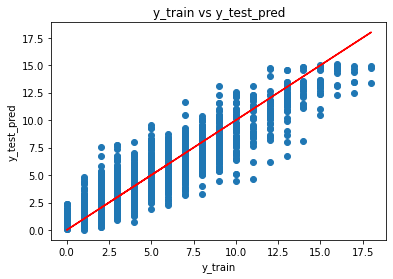

/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's l2: 29.9501
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 24.7823
[3]	valid_0's l2: 20.6382
[4]	valid_0's l2: 17.2814
[5]	valid_0's l2: 14.5708
[6]	valid_0's l2: 12.3705
[7]	valid_0's l2: 10.6735
[8]	valid_0's l2: 9.21383
[9]	valid_0's l2: 8.89938
[10]	valid_0's l2: 7.77882
[11]	valid_0's l2: 6.98724
[12]	valid_0's l2: 6.2486
[13]	valid_0's l2: 6.11669
[14]	valid_0's l2: 5.53445
[15]	valid_0's l2: 5.07039
[16]	valid_0's l2: 4.69053
[17]	valid_0's l2: 4.39035
[18]	valid_0's l2: 4.15159
[19]	valid_0's l2: 3.9751
[20]	valid_0's l2: 3.80209
[21]	valid_0's l2: 3.66372
[22]	valid_0's l2: 3.55374
[23]	valid_0's l2: 3.4642
[24]	valid_0's l2: 3.38972
[25]	valid_0's l2: 3.32768
[26]	valid_0's l2: 3.28369
[27]	valid_0's l2: 3.24305
[28]	valid_0's l2: 3.22291
[29]	valid_0's l2: 3.20123
[30]	valid_0's l2: 3.18093
[31]	valid_0's l2: 3.16089
[32]	valid_0's l2: 3.15676
[33]	valid_0's l2: 3.15785
[34]	valid_0's l2: 3.16063
[35]	valid_0's l2: 3.1601
[36]	va

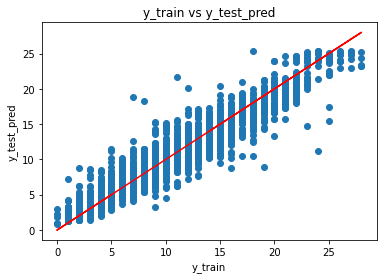

In [1103]:
# スコアを表示。小さいほどよい
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5
# print("test score: ",rmsle(y_test, model.predict(X_test)))
# print("train score: ",rmsle(y_train, model.predict(X_train)))

casual = pred(df, train, test, 'casual')
registered = pred(df, train, test, 'registered')

In [1104]:
submission  = pd.read_csv('input/sampleSubmission.csv')
datetime = pd.DataFrame(submission['datetime'])
result = pd.concat([datetime, casual, registered], axis=1)

result['count'] = result['casual'] + result['registered']
result['count'] = round(result['count'],0).astype('int64')

display(result.describe())

result.loc[result['count']<0, 'count'] = 0

submission = result[['datetime','count']]
submission.to_csv('output/submission.csv',index=False)

,casual,registered,count
count,6493.000000,6493.000000,6493.000000
mean,29.416070,140.073188,169.482828
std,39.247429,131.962108,155.659278
min,0.001830,1.295827,1.000000
25%,3.215485,35.229799,39.000000
50%,14.195637,112.154563,133.000000
75%,40.377593,198.217430,256.000000
max,226.325837,655.377222,744.000000
